In [2]:
import os
import sys
import random

import numpy as np
import pandas as pd
import tensorflow as tf


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import keras

from keras.metrics import MeanIoU
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from  keras_preprocessing.image   import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import layers
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD, schedules, Adam
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers import concatenate, add
from keras.models import Model, load_model
from tensorflow.python.keras import losses

In [3]:
dpath = "Dataset_BUSI\Dataset_BUSI_with_GT/"

In [4]:
data = {'image' : [],
        'mask' : []}
classes = ['benign', 'malignant', 'normal']
image_height = 256
image_width = 256

In [5]:
def load_data(path, data_obj, class_name):
    img_names_list = os.listdir(path+class_name)
    image_names = []
    mask_names = []
    names_truncated = []
    
    for i in range(len(img_names_list)):
        names_truncated.append(img_names_list[i].split(')')[0])
    
    names_truncated = list(set(names_truncated))
    
    for i in range(len(names_truncated)):
        image_names.append(names_truncated[i]+').png')
        mask_names.append(names_truncated[i]+')_mask.png')
    
    data_obj = preprocess_data(image_names, mask_names, image_width, image_height, path, class_name, data_obj)
        
        
    return data_obj

In [6]:
def preprocess_data(image_names, mask_names, img_width, img_height, dpath, dclass, data_obj):
    for index in range (len(image_names)):
        image_path = dpath+'/'+dclass+'/'+ image_names[index]
        mask_path = dpath+'/'+dclass+'/'+ mask_names[index]
        
        x = cv2.imread(image_path, cv2.IMREAD_COLOR)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        x = np.round(cv2.resize(x, (image_height, image_width)))
        x.dtype = np.uint8
        y = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        y = cv2.resize(y, (image_height, image_width))

        x= x/255.0
        y= y/255.0
        data_obj['image'].append(x)
        data_obj['mask'].append(y)

    return data_obj

In [7]:
data = load_data(dpath, data, classes[0]) 
ln = len(data['image'])
print("Number of benign tumor images", ln)
data = load_data(dpath, data, classes[1]) 
print("Number of malignant tumor images", len(data['image'])-ln)
print("Total images for segmentation", len(data['image']))

Number of benign tumor images 437
Number of malignant tumor images 210
Total images for segmentation 647


In [8]:
def visualize_example(data, index = None):
    if index is None:
        index = random.randint(0, len(data['image']))
    X = data['image']
    y = data['mask']
    has_mask = y[index].max() > 0
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    ax[0].imshow(X[index])
    if has_mask:
        ax[0].set_title('Image')

    ax[1].imshow(y[index].squeeze())
    ax[1].set_title('Mask')

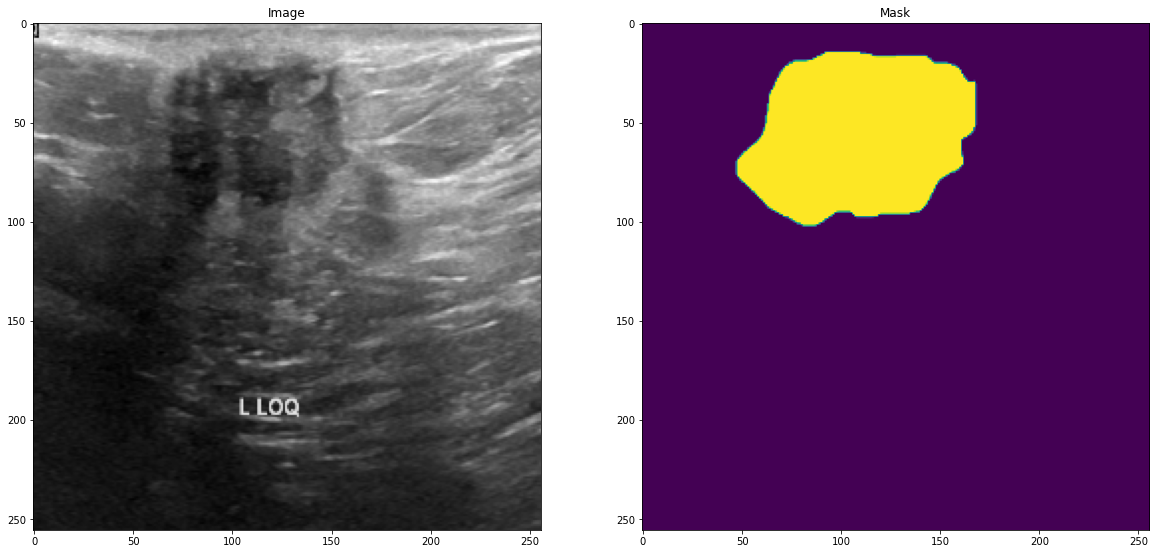

In [9]:
visualize_example(data)

In [10]:
data['image'] = np.array(data['image'])
data['image'].shape

(647, 256, 256, 3)

In [11]:
data['mask'] = np.array(data['mask'])
data['mask'] =  np.expand_dims(data['mask'], -1)
data['mask'].shape

(647, 256, 256, 1)

In [13]:
X_train, X_test, y_train, y_test  = train_test_split(data['image'], data['mask'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
print(len(X_train), len(y_train), len(X_val), len(y_val),len(X_test), len(y_test))

387 387 130 130 130 130


In [14]:
X_train = np.reshape(X_train, (len(X_train), 256, 256, 3))
y_train = np.reshape(y_train, (len(y_train), 256, 256, 1))
X_val = np.reshape(X_val, (len(X_val), 256, 256, 3))
y_val = np.reshape(y_val, (len(y_val), 256, 256, 1))
X_test = np.reshape(X_test, (len(X_test), 256, 256, 3))
y_test = np.reshape(y_test, (len(y_test), 256, 256, 1))

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# AlexNet modeli oluşturma
model = Sequential()

# 1. katman: Convolutional layer
model.add(Conv2D(96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=(256, 256, 3)))

# 2. katman: Max pooling
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# 3. katman: Convolutional layer
model.add(Conv2D(256, kernel_size=(5, 5), activation='relu'))

# 4. katman: Max pooling
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# 5. katman: Convolutional layer
model.add(Conv2D(384, kernel_size=(3, 3), activation='relu'))

# 6. katman: Convolutional layer
model.add(Conv2D(384, kernel_size=(3, 3), activation='relu'))

# 7. katman: Convolutional layer
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))

# 8. katman: Max pooling
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# 9. katman: Fully connected layer
model.add(Flatten())
model.add(Dense(4096, activation='relu'))

# 10. katman: Fully connected layer
model.add(Dense(4096, activation='relu'))

# 11. katman: Fully connected layer
# 11. katman: Fully connected layer
model.add(Dense(1000, activation='relu'))

# Çıkış katmanı
model.add(Flatten())
model.add(Dense(256 * 256, activation='sigmoid'))
model.add(tf.keras.layers.Reshape((256, 256, 1)))


#model.add(Dense(1000, activation='relu'))

# 12. katman: Çıkış katmanı
#model.add(Dense(1, activation='softmax'))


# Modeli derleme
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
callbacks = [
    EarlyStopping(patience=10, verbose=1), 
    ModelCheckpoint('model-checkpoint.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 62, 62, 96)        34944     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 30, 30, 96)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 256)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 10, 384)       885120    
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 384)        

In [18]:
results=model.fit(X_train, y_train, batch_size=32, epochs=18, validation_data=(X_val, y_val),callbacks=callbacks)

Epoch 1/18
13/13 [==============================] - ETA: 0s - loss: 0.3926 - accuracy: 0.8756
Epoch 1: val_loss improved from inf to 0.39827, saving model to model-checkpoint.h5
13/13 [==============================] - 27s 2s/step - loss: 0.3926 - accuracy: 0.8756 - val_loss: 0.3983 - val_accuracy: 0.8929
Epoch 2/18
13/13 [==============================] - ETA: 0s - loss: 0.2707 - accuracy: 0.9082
Epoch 2: val_loss improved from 0.39827 to 0.26147, saving model to model-checkpoint.h5
13/13 [==============================] - 29s 2s/step - loss: 0.2707 - accuracy: 0.9082 - val_loss: 0.2615 - val_accuracy: 0.8930
Epoch 3/18
13/13 [==============================] - ETA: 0s - loss: 0.2391 - accuracy: 0.9084
Epoch 3: val_loss improved from 0.26147 to 0.26106, saving model to model-checkpoint.h5
13/13 [==============================] - 30s 2s/step - loss: 0.2391 - accuracy: 0.9084 - val_loss: 0.2611 - val_accuracy: 0.8931
Epoch 4/18
13/13 [==============================] - ETA: 0s - loss: 0.2

In [19]:
# Modelin performansını değerlendirme
loss, accuracy = model.evaluate(X_test, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

5/5 [==============================] - 1s 248ms/step - loss: 0.2239 - accuracy: 0.9101
Test loss: 0.22385509312152863
Test accuracy: 0.9100937843322754


NameError: name 'x' is not defined

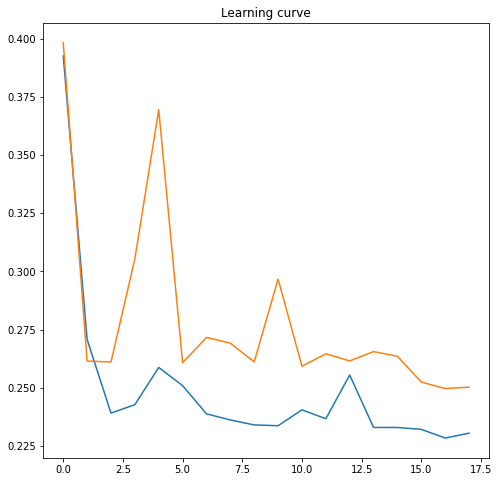

In [25]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), color="r", label="best model", marked=x)
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend();

In [21]:
score = model.evaluate(X_test, y_test, verbose = 1) 
print('Test loss:', score[0]) 
print('Test accuracy:', score[1]*100)

5/5 [==============================] - 1s 256ms/step - loss: 0.2239 - accuracy: 0.9101
Test loss: 0.22385509312152863
Test accuracy: 91.00937843322754


In [22]:
preds_test = model.predict(X_test, verbose=1)

5/5 [==============================] - 1s 233ms/step


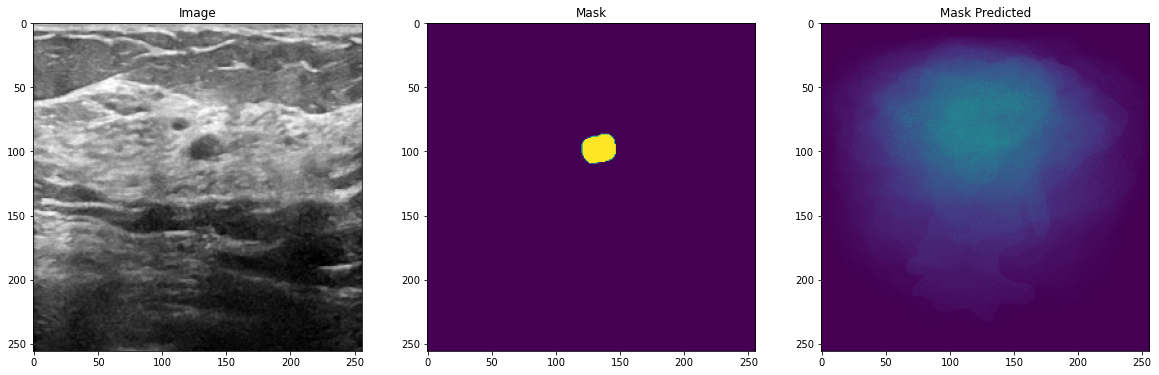

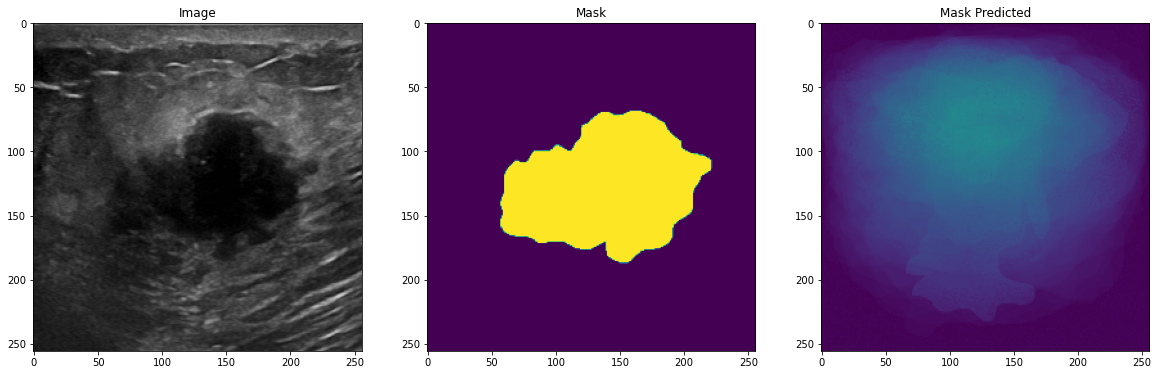

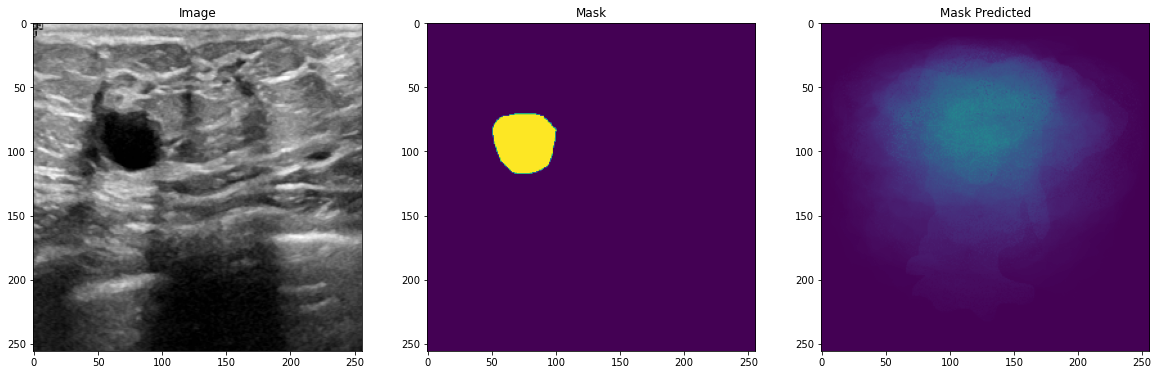

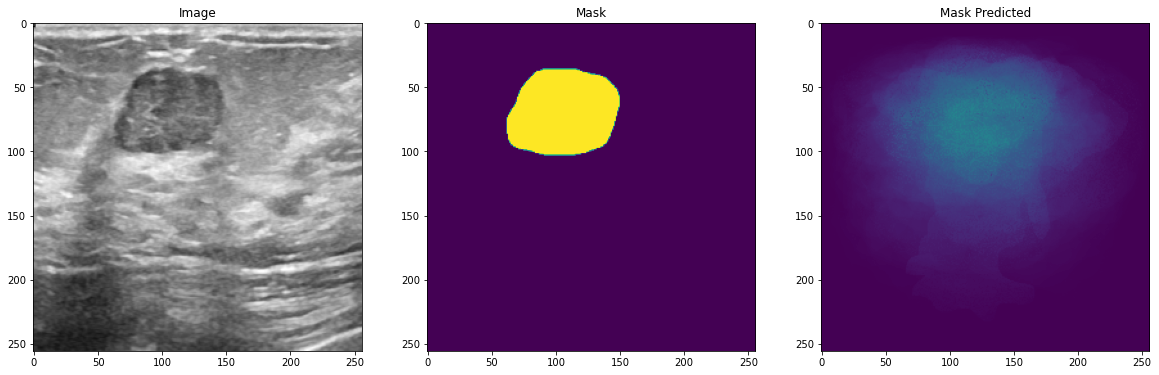

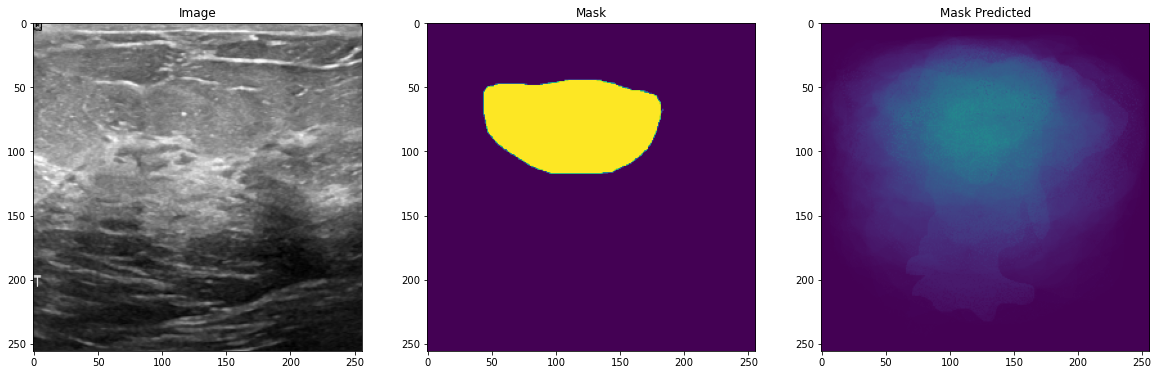

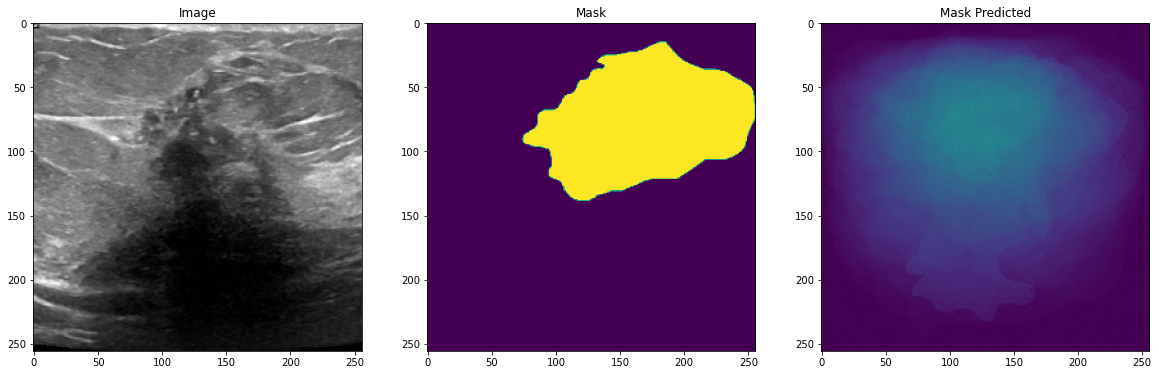

In [23]:
def plot_sample(X, y, preds, ix):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(X[ix])
    if has_mask:
        ax[0].set_title('Image')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Mask')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    ax[2].set_title('Mask Predicted')
    
plot_sample(X_test, y_test, preds_test, 12)
plot_sample(X_test, y_test, preds_test, 17)
plot_sample(X_test, y_test, preds_test, 32)
plot_sample(X_test, y_test, preds_test, 65)
plot_sample(X_test, y_test, preds_test, 15)
plot_sample(X_test, y_test, preds_test, 96)